In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()


scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))

if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

from openspliceai_helpers import openspliceai_predict
from common import extract_quadruplet_rows, performance_metrics

In [2]:
df = pd.read_csv("../ref/hbvdb/pgrna/pgrna_flank200.txt", header=None, sep="\t")
flanking_size = 400
model = f"../src/OpenSpliceAI/models/openspliceai-mane/{flanking_size}nt/model_{flanking_size}nt_rs14.pt"

df["preds"] = df[3].progress_apply(lambda x: openspliceai_predict(x, model, flanking_size))
df["length"] = df[3].apply(len)
bf = df[df["length"]==3639].copy()
bf["seq"] = bf[3].apply(lambda x: x[200:3440])

  0%|          | 0/7501 [00:00<?, ?it/s]

In [3]:
preds = pd.concat(bf["preds"].tolist())
preds.reset_index(drop=True, inplace=True)
preds["id"] = bf[0].repeat(3240).reset_index()[0]
preds["base"] = list(''.join(bf["seq"].tolist()))
preds["genotype"] = bf[1].repeat(3240).reset_index()[1]
preds["genotype"] = preds["genotype"].str.replace(".fa","")

aset = preds[(preds.genotype.str.contains("B|C|RF|F")) & (~preds.genotype.str.contains("RFC"))].copy()
aset.columns = [0,"acceptor probability","donor probability","position","id","base","genotype"]

Prediction results for splice donor sites

In [4]:
x,g,t,y = extract_quadruplet_rows(aset.reset_index(drop=True), "base", "G", "T", pre_value_any=True)
x["position"] = x["position"] + 1../results/figures/

In [5]:
cosi_long = pd.read_pickle("../data/processed_files/cosi_long.pkl.gz")
h = cosi_long[cosi_long["Splicing efficiency"]>=0.1].copy()
h["group"] = "Higher usage"

l = cosi_long[cosi_long["Splicing efficiency"]<0.1].copy()
l["group"] = "Lower usage"

hl = pd.concat([h,l])

pos = hl[hl["coSI"]=='$\\theta_5$'].copy()
pos["position"] =  pos["start"]

In [6]:
a = pd.merge(x, pos[["position","group","Splicing efficiency","Splice site"]], how="left")
a = a.sort_values("Splicing efficiency", ascending=False).drop_duplicates(["position",0,"acceptor probability","donor probability","id","genotype"])
a["group"] = a["group"].fillna("Non-donor")

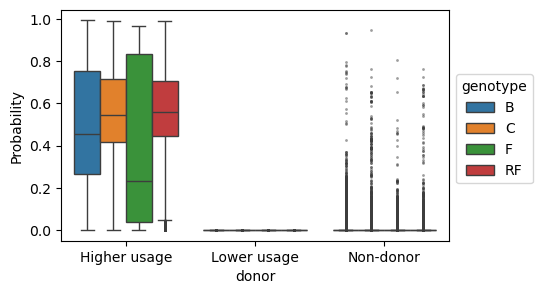

In [7]:
plt.figure(figsize=(5,3))

flierprops = dict(markersize=1, alpha=0.5)
g = sns.boxplot(data=a.sort_values("genotype"), x="group", y="donor probability", hue="genotype", 
                order=["Higher usage","Lower usage","Non-donor"],
                palette="tab10", flierprops=flierprops)

plt.xlabel("donor")
plt.ylabel("Probability")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))
plt.savefig("../results/figures/fig5/openspliceai_donors.png", bbox_inches='tight', dpi=300)

In [8]:
a.value_counts("group")

group
Non-donor       757682
Higher usage     25840
Lower usage      14277
Name: count, dtype: int64

In [9]:
a.drop_duplicates(["Splice site","genotype","position"]).value_counts(["Splice site","genotype"])

Splice site  genotype
donor        B           11
             RF          11
             C           10
             F           10
Name: count, dtype: int64

Calculate performance metrics for splice donor sites

In [10]:
usage = {'Higher usage':1, 'Lower usage':1, 'Non-donor':0}

a["label"] = a.group.apply(lambda x: usage[x])

y_true = a["label"].to_numpy()
y_pred = a["donor probability"].to_numpy()

In [11]:
performance_metrics(y_true, y_pred, 0.5)


AUROC: 0.78
AUPRC: 0.61

Predicted binary labels unique values: [0 1]

Metrics at threshold=0.5:
Accuracy: 0.97
F1-Score: 0.51
Precision: 0.99
Recall: 0.34

Classification Report at threshold=0.5:
              precision    recall  f1-score   support

Not Positive       0.97      1.00      0.98    757682
    Positive       0.99      0.34      0.51     40117

    accuracy                           0.97    797799
   macro avg       0.98      0.67      0.75    797799
weighted avg       0.97      0.97      0.96    797799



Prediction results for splice acceptor sites

In [12]:
x,a,g,y = extract_quadruplet_rows(aset.reset_index(drop=True), "base", "A", "G", pre_value_any=True)
# n["position"] = n["position"] + 1

In [13]:
pos = hl[hl["coSI"]=='$\\theta_3$'].copy()
pos["position"] =  pos["end"]

In [14]:
a = pd.merge(y, pos[["position","group","Splicing efficiency","Splice site"]], how="left")
a = a.sort_values("Splicing efficiency", ascending=False).drop_duplicates(["position",0,"acceptor probability","donor probability","id","genotype"])
a["group"] = a["group"].fillna("Non-acceptor")

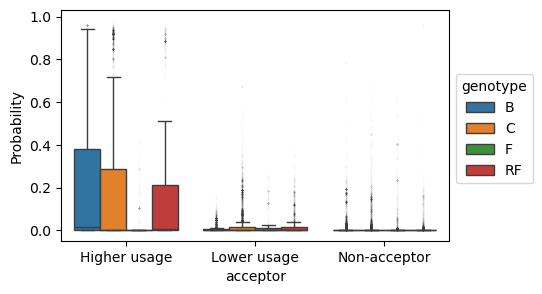

In [15]:
plt.figure(figsize=(5,3))

flierprops = dict(markersize=1, alpha=0.005)
g = sns.boxplot(data=a.sort_values("genotype"), x="group", y="acceptor probability", hue="genotype", 
                order=["Higher usage","Lower usage","Non-acceptor"],
                palette="tab10", flierprops=flierprops)

plt.xlabel("acceptor")
plt.ylabel("Probability")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))
plt.savefig("../results/figures/fig5/openspliceai_acceptors.png", bbox_inches='tight', dpi=300)

In [16]:
a.value_counts("group")

group
Non-acceptor    652160
Lower usage      47042
Higher usage     20220
Name: count, dtype: int64

In [17]:
a.drop_duplicates(["Splice site","genotype","position"]).value_counts(["Splice site","genotype"])

Splice site  genotype
acceptor     C           18
             B           17
             RF          17
             F           15
Name: count, dtype: int64

Calculate performance metrics for splice donor sites

In [18]:
usage = {'Higher usage':1, 'Lower usage':1, 'Non-acceptor':0}

a["label"] = a.group.apply(lambda x: usage[x])

y_true = a["label"].to_numpy()
y_pred = a["acceptor probability"].to_numpy()

In [19]:
performance_metrics(y_true, y_pred, 0.5)


AUROC: 0.89
AUPRC: 0.57

Predicted binary labels unique values: [0 1]

Metrics at threshold=0.5:
Accuracy: 0.91
F1-Score: 0.13
Precision: 0.97
Recall: 0.07

Classification Report at threshold=0.5:
              precision    recall  f1-score   support

Not Positive       0.91      1.00      0.95    652160
    Positive       0.97      0.07      0.13     67262

    accuracy                           0.91    719422
   macro avg       0.94      0.53      0.54    719422
weighted avg       0.92      0.91      0.88    719422

